In [114]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
algorithm_globals.random_seed = 1234
%matplotlib inline

In [115]:
def qubo_matrix(imgs, penalty, y, N):
    J = np.zeros((N, N))
    h = np.zeros(N)
    for i in range(N):
        for j in range(N):
            J[i, j] = sum([h_1[i](imgs[s]) * h_1[j](imgs[s]) / N**2 for s in range(S)])
        h[i] = sum([h_1[i](imgs[s]) * (2 * y[s] - 1) / N for s in range(S)])
    h *= -2
    h += penalty
    h += S / N**2
    J += np.diag(h)
    return J

In [116]:
#  итерируемся по обработанным картинкам
directory = 'cut_images'
intensities_and_states = []
intensity_image_state = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    num_img, num_ion, state = map(int, filename[:-4].split("_"))
    img = np.array(Image.open(f))
    intensity = np.mean(img)
    intensities_and_states.append([intensity, state])
    intensity_image_state.append([intensity, img, state])

IIS = sorted(intensity_image_state, key=lambda x: x[0])
S = len(IIS)

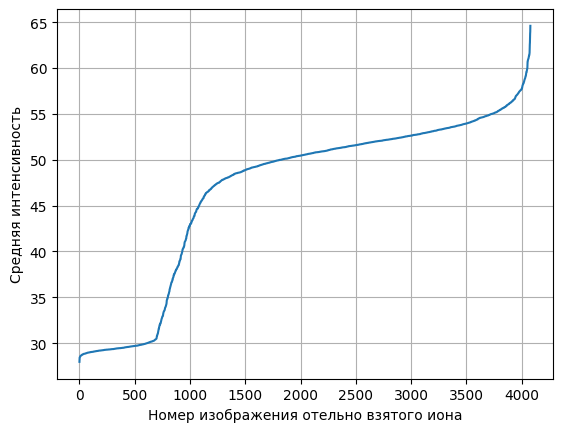

In [117]:
plt.plot(np.array(sorted(intensities_and_states, key=lambda x: x[0])).T[0])
plt.xlabel('Номер изображения отельно взятого иона')
plt.ylabel('Средняя интенсивность')
plt.grid()

Попробуем найти значения thresholds в районе резкого перепада, которые могли бы отделять картинки с label 0 и 1 соотв.

In [118]:
zero_index = 1  # номер изображения, где будет встречен последний label = 0
one_index = 1 # номер изображения, где будет встречен первый label = 1
for i in range(S):
    if IIS[i][-1] == 1:
        one_index = i
        break
    elif IIS[i][-1] == 0:
        zero_index = i

#  исскуственно зашумим данные в окрестности точки резкого изменения графика интенсивности (~700),
#  то есть поменяем для случайно взятых картинок их lable на противоположный

dif = 11
for r in np.random.randint(zero_index - dif, one_index + dif, size=dif):
    IIS[r][-1] = 1 - IIS[r][-1]

Введём понятие слабого классификатора h_1, который по сути показывает для заданной картинки, больше ли срендяя интенсивность картинки некоторого значения threshold. Пусть таких классификаторов будет N штук. Также введём понятие сильного классификатора, который является линейной комбинацией всех слабых классификаторов с коэффициентами w_i (веса, с которыми мы учитываем вклад i-го слабого классификатора; бинарная переменная, то есть либо учитываем, либо нет).

In [119]:
N = 10

In [120]:
theta = np.unique([x[0] for x in IIS[zero_index - dif:one_index + dif]])  # введенные выше tresholds
np.random.shuffle(theta)
h_1 = {i: lambda img: np.sign(np.mean(img) - theta[i]) for i in range(theta.shape[0])}  # слабые классификаторы

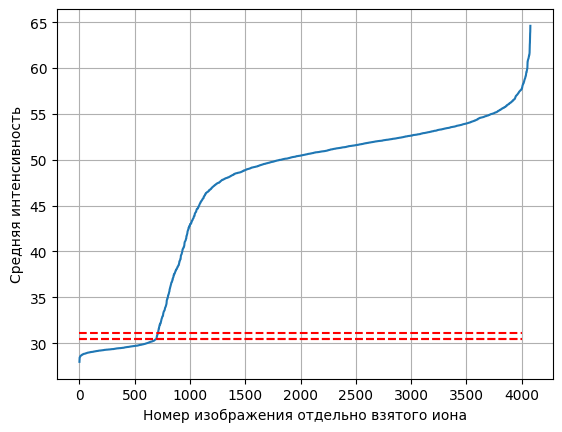

In [121]:
plt.plot(np.array(sorted(intensities_and_states, key=lambda x: x[0])).T[0])
plt.xlabel('Номер изображения отдельно взятого иона')
plt.ylabel('Средняя интенсивность')
plt.hlines(theta[::8], 0, 4000, color='r', linestyles='--')
plt.grid()

In [122]:
imgs = np.array([x[1] for x in IIS])
y_true = np.array([x[-1] for x in IIS])
y_true = 2 * y_true - 1  # перевод из разметки (0, 1) в (-1, 1)
penalty = 700

In [123]:
qm = qubo_matrix(imgs, penalty, y_true, N)

In [124]:
qubo = QuadraticProgram()

for i in range(N):
    qubo.binary_var(name=f"w{i}")
    
qubo.minimize(quadratic=qm)

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())

qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qubo)

In [125]:
print(qaoa_result.prettyprint())

objective function value: -720.9600000005058
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1.0, w4=0.0, w5=0.0, w6=0.0, w7=0.0, w8=0.0, w9=0.0
status: SUCCESS


In [126]:
w_opt = qaoa_result.x
T = sum([w_opt[n] * sum([h_1[i](imgs[s]) for s in range(S)]) for n in range(N)]) / S
y_pred = [sum([w_opt[i] * h_1[i](imgs[s]) for i in range(N)]) for s in range(S)]  # предсказанные lable
y_pred = np.sign(y_pred - T)

In [127]:
accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)

(0.9975490196078431, 0.9985220218740762)

Представление результатов

In [128]:
directory = 'cut_images'
df = {}
states = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    num_img, num_ion, state = map(int, filename[:-4].split("_"))
    img = np.array(Image.open(f))
    y_pred = np.sign(sum([w_opt[i] * h_1[i](img) for i in range(N)]) - T)
    df.setdefault(f"Qubit {num_ion + 1} state", []).append((1 + y_pred) / 2)
df = pd.DataFrame(df)
df.head()

,Qubit 1 state,Qubit 2 state,Qubit 3 state,Qubit 4 state
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,0.0,1.0,1.0
4,1.0,0.0,1.0,1.0


In [129]:
df['Class'] =  df['Qubit 1 state'] * 2**0 + df['Qubit 2 state'] * 2**1 + df['Qubit 3 state'] * 2**2 + df['Qubit 4 state'] * 2**3

In [130]:
Category = list(['|0000>', '|0001>','|0010>','|0011>',
                 '|0100>', '|0101>','|0110>','|0111>',
                 '|1000>', '|1001>','|1010>','|1011>',
                 '|1100>', '|1101>','|1110>','|1111>'])

In [131]:
import plotly.express as px

# создадим объект fig, в который поместим столбчатую диаграмму
fig = px.histogram(df, x=df.Class, nbins=16)

# применим метод .update_layout к объекту fig
fig.update_layout(
    title_text = 'Распределение состояния ионов (кубитов) по автоматической разметке', # заголовок
    xaxis_title_text = 'State', # подпись к оси x
    yaxis_title_text = 'Count', # подпись к оси y
    bargap = 0.2, # расстояние между столбцами

    # подписи классов на оси x
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
        ticktext = Category #['Class 1', 'Class 2', 'Class 3'...]
    )
)

fig.show()

Анализ предложенного алгоритма. Посмотрим на зависимости от N и от penalty

In [136]:
directory = 'cut_images'
intensities_and_states = []
intensity_image_state = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    num_img, num_ion, state = map(int, filename[:-4].split("_"))
    img = np.array(Image.open(f))
    intensity = np.mean(img)
    intensities_and_states.append([intensity, state])
    intensity_image_state.append([intensity, img, state])

IIS = sorted(intensity_image_state, key=lambda x: x[0])
S = len(IIS)

for penalty in [200, 500, 700]:
    for N in [5, 7, 9]:

        zero_index = 1
        one_index = 1
        for i in range(S):
            if IIS[i][-1] == 1:
                one_index = i
                break
            elif IIS[i][-1] == 0:
                zero_index = i

        dif = 25
        for r in np.random.randint(zero_index - dif, one_index + dif, size=dif):
            IIS[r][-1] = 1 - IIS[r][-1]

        theta = np.unique([x[0] for x in IIS[zero_index - dif:one_index + dif]])
        np.random.shuffle(theta)
        h_1 = {i: lambda img: np.sign(np.mean(img) - theta[i]) for i in range(theta.shape[0])}

        imgs = np.array([x[1] for x in IIS])
        y_true = np.array([x[-1] for x in IIS])
        y_true = 2 * y_true - 1

        qm = qubo_matrix(imgs, penalty, y_true, N)
        qubo = QuadraticProgram()

        for i in range(N):
            qubo.binary_var(name=f"w{i}")

        qubo.minimize(quadratic=qm)
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        qaoa_result = qaoa.solve(qubo)
        print(f"For N = {N}, penalty = {penalty}:\n", qaoa_result.prettyprint(), '\n')

        w_opt = qaoa_result.x
        T = sum([w_opt[n] * sum([h_1[i](imgs[s]) for s in range(S)]) for n in range(N)]) / S
        y_pred = [sum([w_opt[i] * h_1[i](imgs[s]) for i in range(N)]) for s in range(S)]
        y_pred = np.sign(y_pred - T)

        print("Accuracy and F1 scores", accuracy_score(y_true, y_pred), f1_score(y_true, y_pred), '\n')

For N = 5, penalty = 200:
 objective function value: -4883.000000001218
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1.0, w4=1.0
status: SUCCESS 

Accuracy and F1 scores 0.9946078431372549 0.9967465246968352 

For N = 7, penalty = 200:
 objective function value: -4552.142857142657
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1.0, w4=1.0, w5=1.0, w6=1.0
status: SUCCESS 

Accuracy and F1 scores 0.9916666666666667 0.994989684644857 

For N = 9, penalty = 200:
 objective function value: -4241.666666665165
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1.0, w4=1.0, w5=1.0, w6=1.0, w7=1.0, w8=1.0
status: SUCCESS 

Accuracy and F1 scores 0.9909313725490196 0.9945532165464449 

For N = 5, penalty = 500:
 objective function value: -2797.1200000007966
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1.0, w4=0.0
status: SUCCESS 

Accuracy and F1 scores 0.9833333333333333 0.9900990099009901 

For N = 7, penalty = 500:
 objective function value: -2042.24489795918
variable values: w0=1.0, w1=1.0, w2=1.0, w3=1

В общем случае при росте N наблюдается снижение качества

In [142]:
df.drop(columns=['Class'], inplace=True)
df.to_csv('labeled_ions_team_9.csv')